Analyse des données

Préparation des données avec pandas


In [209]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import polars as pl
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from cleaner import DataCleaner
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tools import (
    logging,
    bins_generator,
    import_datasets,
    decode_clean,

)
import eda_movies as eda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
link = "big_dataframe/movies.csv"
df = eda.eda_movies(link)

2023-10-26 13:57:02 INFO     Pandas loaded ! Importing movies...
2023-10-26 13:57:03 INFO     Fixing N values...
2023-10-26 13:57:03 INFO     Fixing encoding values...
2023-10-26 13:57:03 INFO     Cleaned : 0 rows


ADD TMDB
AND
AKAS

In [232]:

line = "tmdb_full.csv"
df_imdb = pd.read_csv(line)

#  Je merge les deux bd
merged = pd.merge(
    df,
    df_imdb,
    left_on="titre_id",
    right_on="imdb_id",
    how="left"
)
logging.info(f"Cleaned : {len(df) - len(merged)} rows")

#  Je drop les colonnes
merged = merged.drop(eda.columns_to_drop_tmdb(), axis=1)
max_ = merged.isna().sum()
logging.info(f"Cleaned NaN Value : {max_.max()}")

# https://fr.wikipedia.org/wiki/D%C3%A9mographie_de_la_Creuse
# https://fr.statista.com/statistiques/498200/preference-films-etrangers-vo-vf-france/
merged = merged.dropna()
logging.info(f"Length dataframe merged with tmdb : {len(merged)}")


col_list = ["spoken_languages", "production_countries"]
merged = eda.clean_square_brackets(
    merged,
    col_list
)
merged = merged.dropna()
logging.info(f"Length dataframe merged cleaned : {len(merged)}")

merged = eda.apply_decode_and_split(
    merged,
    col_list,
    decode_clean
)

# Importation Akas !
akas = import_datasets(
    "movies_datasets/title_akas.tsv",
    types="pandas",
    sep="\t"
)

akas = akas[akas["region"] == 'FR']
region_only = akas[["titleId", "region"]]

#  Merge de akas avec la base de donnée merged (df movies inclus)
logging.info("Merging tmdb and akas dataframes...")
added_region = pd.merge(
    merged,
    region_only,
    left_on="titre_id",
    right_on="titleId"
)
df = added_region

logging.info("Drop all duplicated movies...")
df.drop_duplicates(subset=["titre_id"], keep="first", inplace=True)

# Conserver les films realeased uinqiuement.
condi = (
    df["status"] == "Released"
)
df = df[condi]

C:\Users\morga\AppData\Local\Temp\ipykernel_22240\1542297665.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imdb = pd.read_csv(line)
2023-10-26 13:57:08 INFO     Cleaned : 0 rows
2023-10-26 13:57:08 INFO     Cleaned NaN Value : 108679
2023-10-26 13:57:08 INFO     Length dataframe merged with tmdb : 185564
2023-10-26 13:57:08 INFO     Length dataframe merged cleaned : 149505
2023-10-26 13:57:09 INFO     Pandas loaded ! Importing title_akas...
c:\Users\morga\OneDrive\AppData\Bureau\WildCodeSchool\z_project_2\tools.py:96: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(datas, sep=sep, encoding="iso-8859-1")
2023-10-26 13:57:43 INFO     Merging tmdb and akas dataframes...
2023-10-26 13:57:46 INFO     Drop all duplicated movies...


In [233]:
df = df.copy()
df = eda.split_columns(df, "titre_genres")
logging.info(f"Top most viewed genre by movies : {eda.get_top_genres(df)}")
df = eda.apply_decade_column(df)
df = eda.drop_nan_values(df)

2023-10-26 13:57:48 INFO     Titre_genres splited !
2023-10-26 13:57:48 INFO     Top most viewed genre by movies : Drama
2023-10-26 13:57:48 INFO     15 cuts created, from 1900 to 2029
2023-10-26 13:57:48 INFO     Cleaned : 198 rows


In [234]:
# df.isnull().sum()

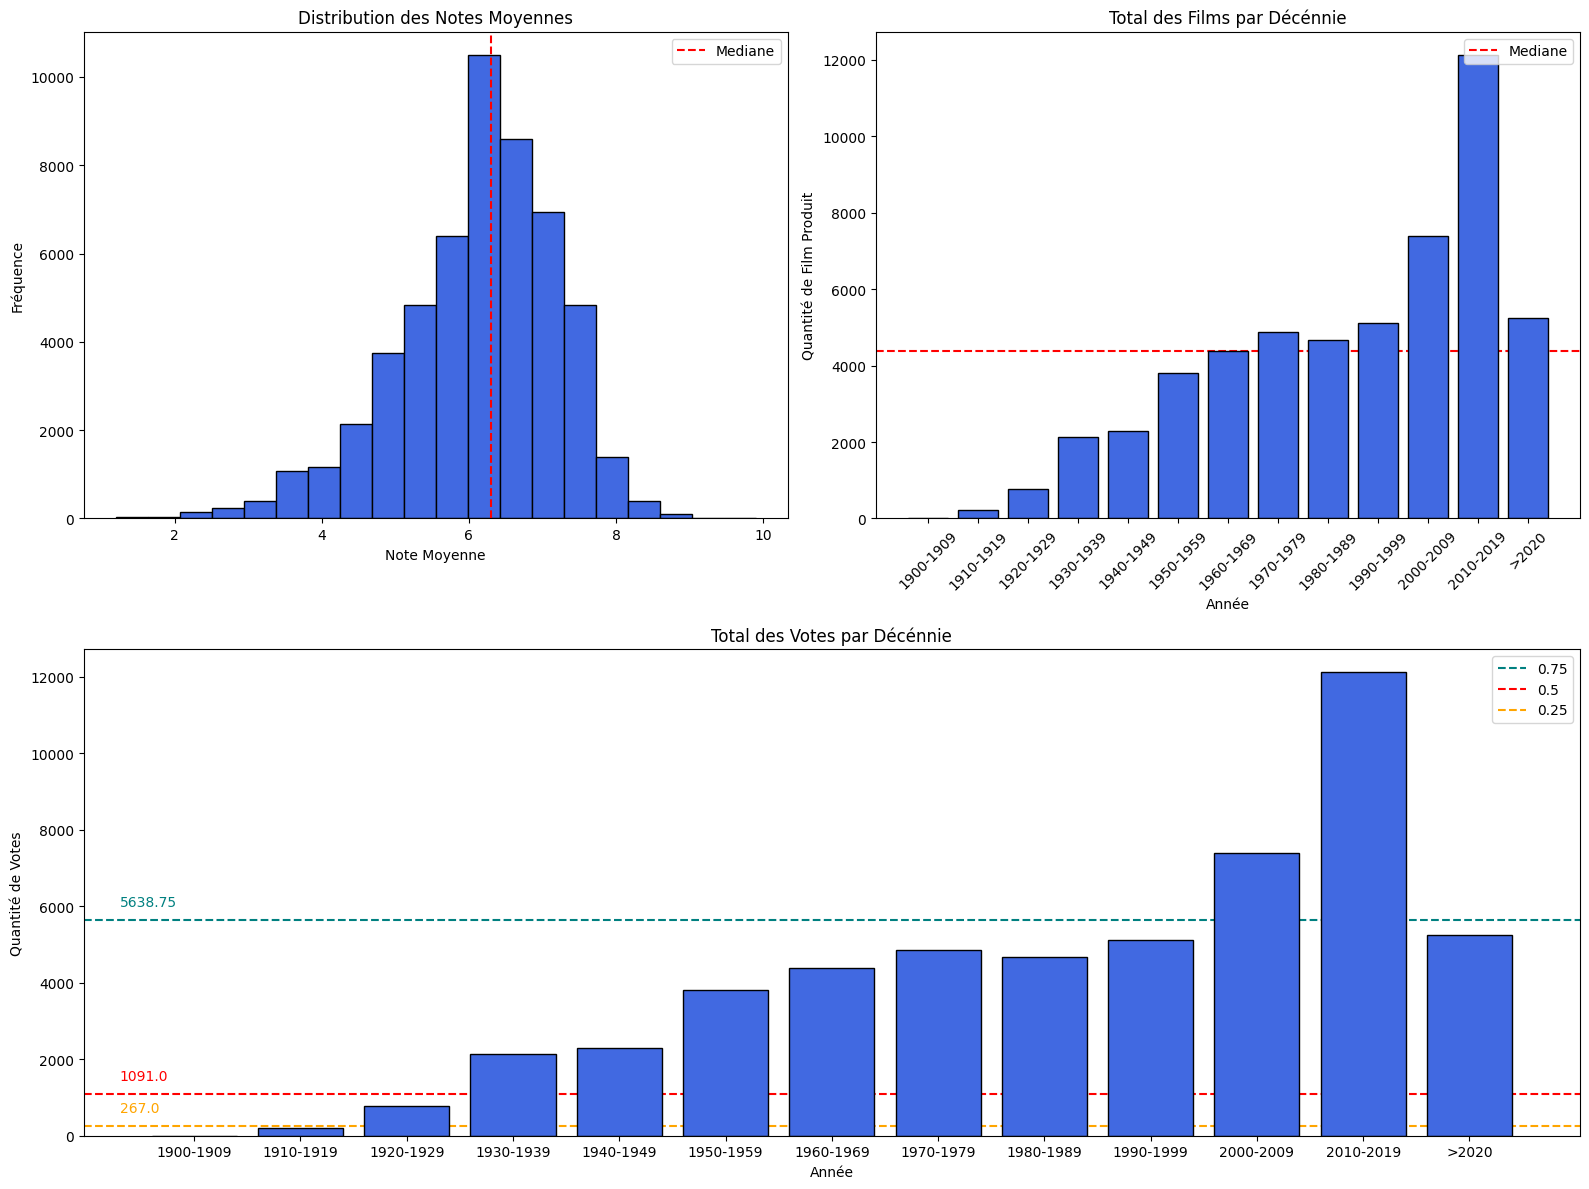

In [235]:
eda.show_total_films_decade(df)

**A partir d'ici nous pouvons definir notre angle d'attaque**
=


**Delete les films en dessous de 1960**

In [236]:
condi =(
    (df["titre_date_sortie"] >= 1960) &
    (df["rating_avg"] >= 5)
)
df = df[condi].reset_index(drop='index')

In [237]:
df.head()

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,production_countries,revenue,spoken_languages,status,titleId,region,cuts
0,tt0035423,Kate & Leopold,2001,118,"[Comedy, Fantasy, Romance]",6.40,87747,en,Kate & Leopold,15.77,[US],76019048.00,"[en, fr, it]",Released,tt0035423,FR,2000-2009
1,tt0036606,"Another Time, Another Place",1983,118,"[Drama, War]",6.50,343,it,"Another Time, Another Place",1.40,[GB],0.00,"[en, it]",Released,tt0036606,FR,1980-1989
2,tt0038687,Let There Be Light,1980,58,"[Documentary, War]",7.40,1977,en,Let There Be Light,3.58,[US],0.00,[en],Released,tt0038687,FR,1980-1989
3,tt0039442,"Habla, mudita",1973,88,[Drama],6.10,163,es,"Habla, mudita",1.01,"[ES, DE]",0.00,[es],Released,tt0039442,FR,1970-1979
4,tt0044952,Nagarik,1977,127,[Drama],8.00,231,bn,নাগরিক,0.76,[IN],0.00,[bn],Released,tt0044952,FR,1970-1979


In [239]:
mf = df.copy()

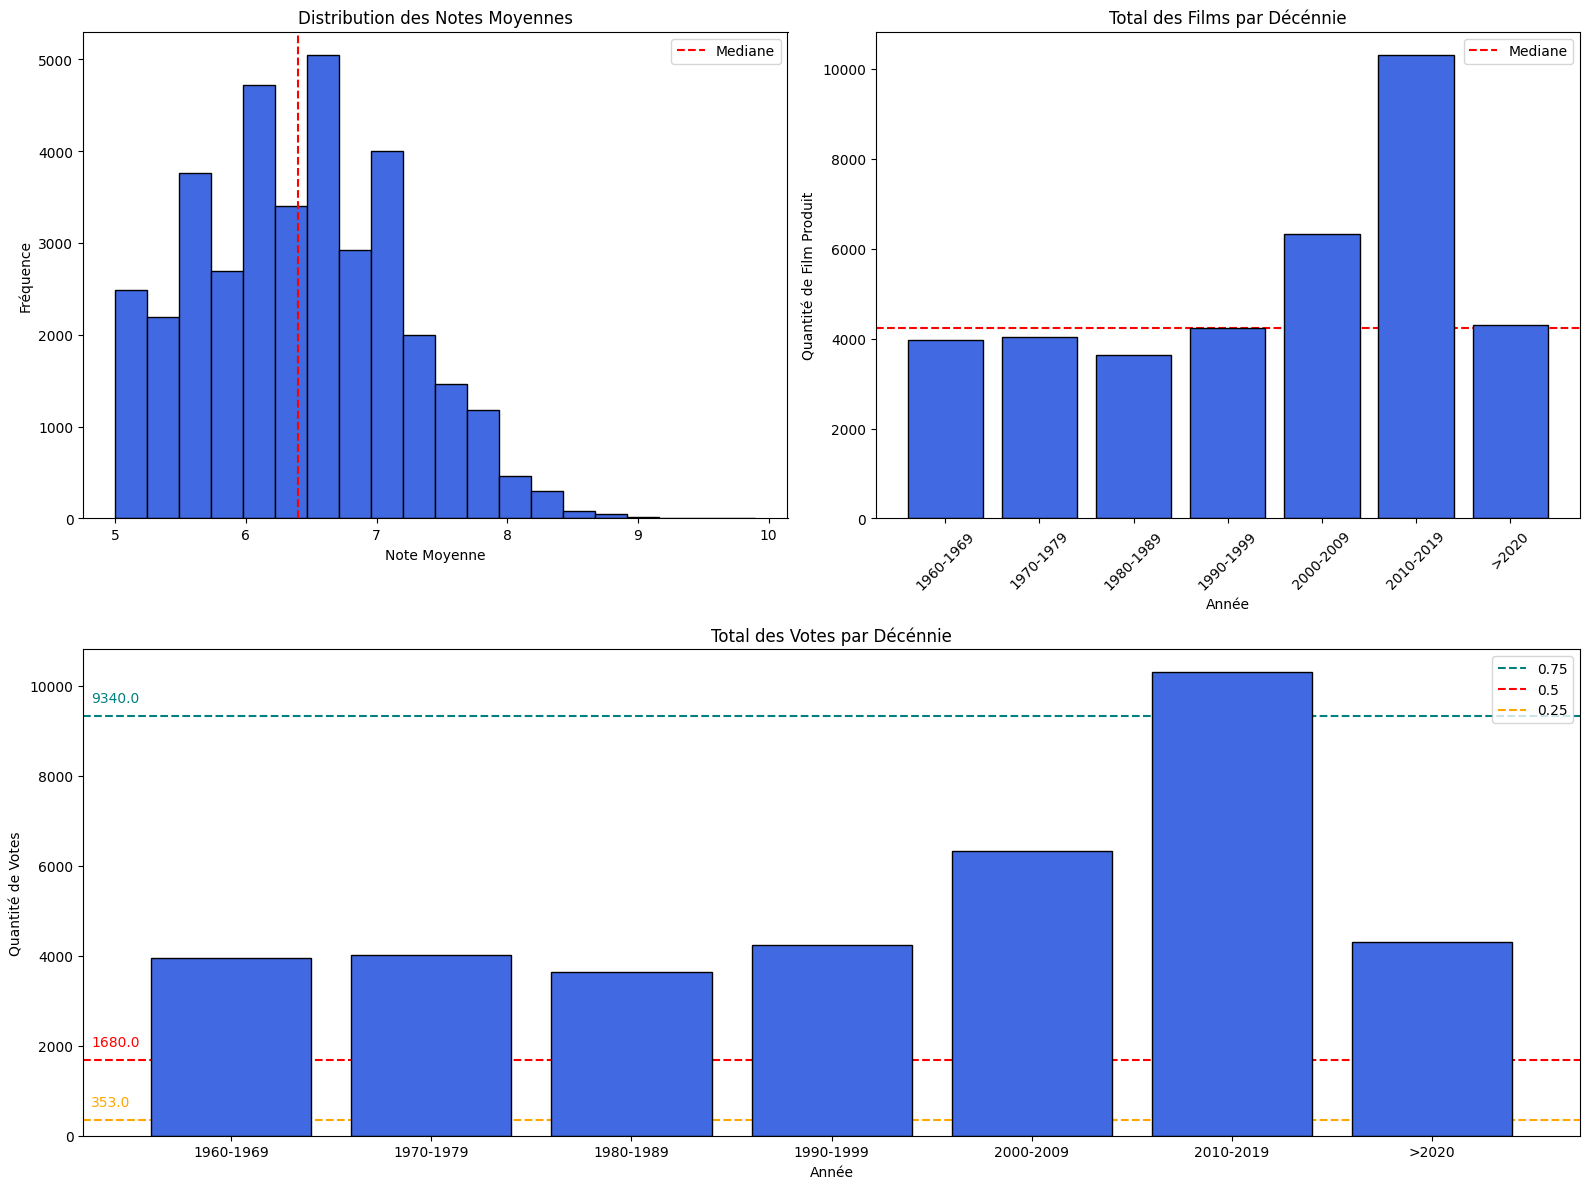

In [240]:
eda.show_total_films_decade(mf)

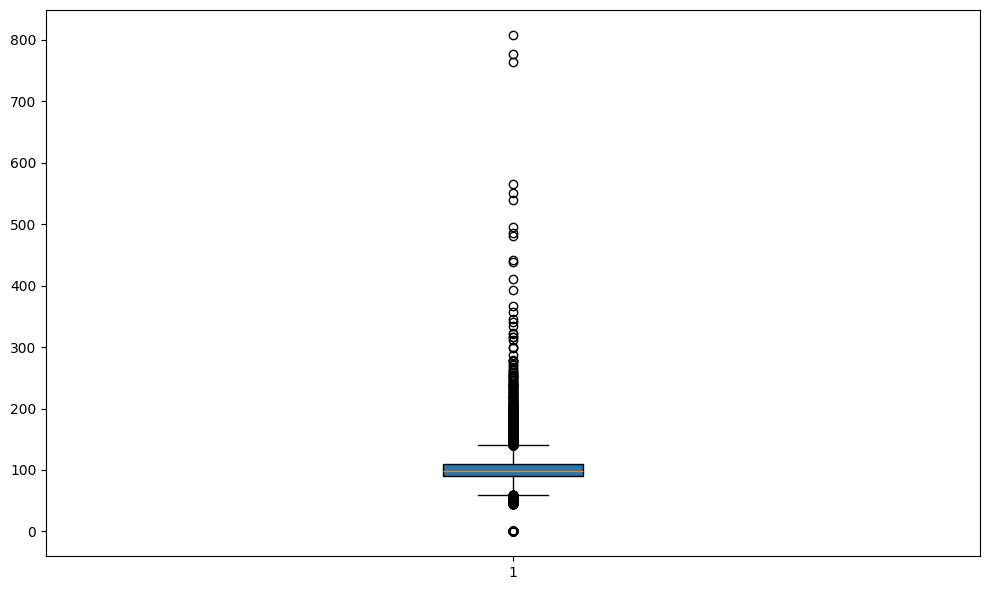

In [241]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    df["titre_duree"],
    patch_artist=True
)
plt.tight_layout()
plt.show()

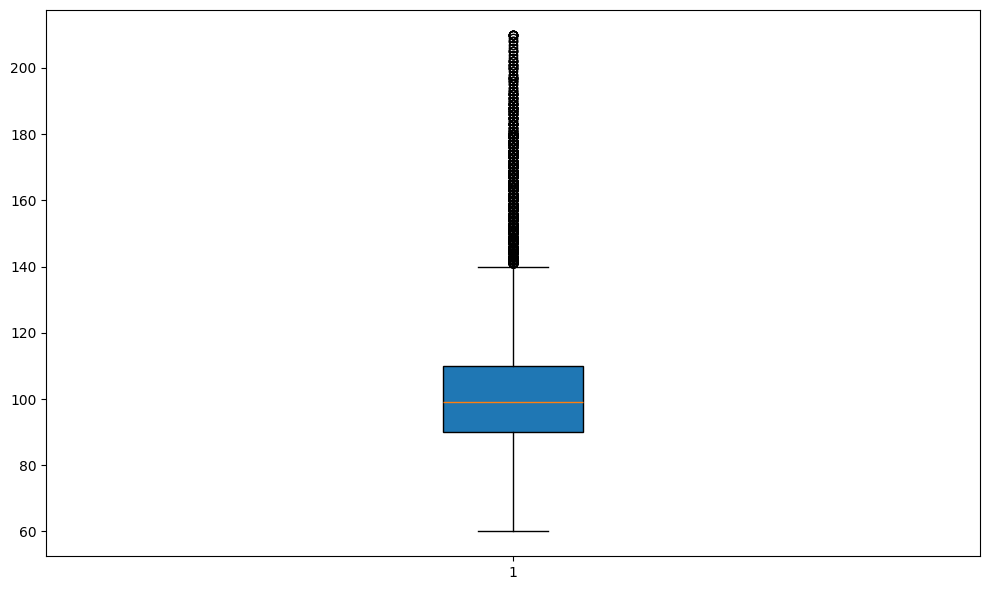

In [242]:
condi =(
    (df["titre_duree"] < 60) | (df["titre_duree"] > 210)
)
df = df[~condi].reset_index(drop='index')
df

plt.figure(figsize=(10, 6))
plt.boxplot(
    df["titre_duree"],
    patch_artist=True
)
plt.tight_layout()
plt.show()

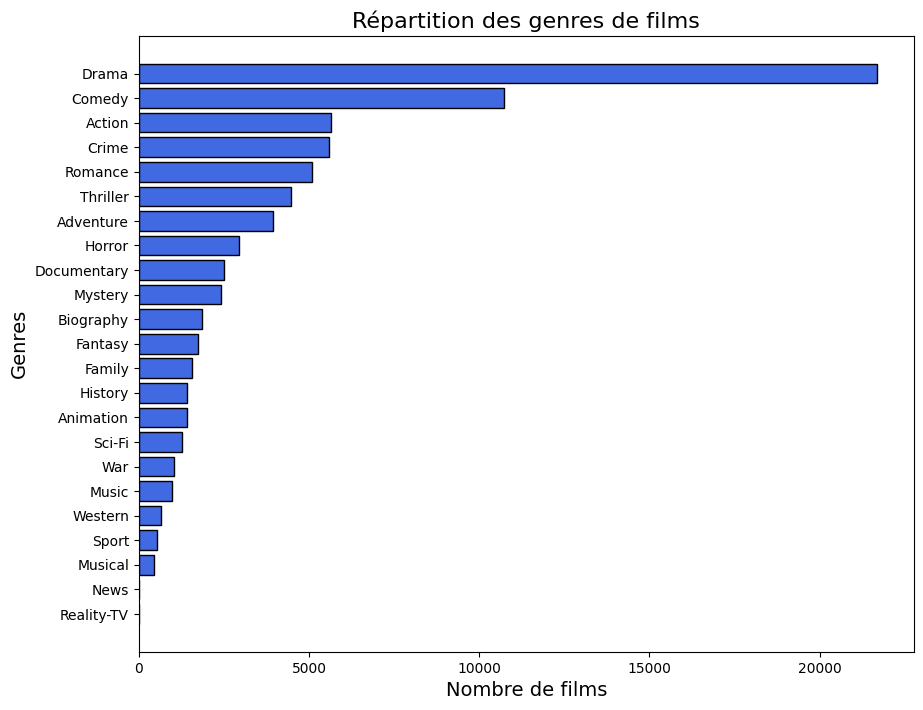

In [243]:
total_genres = df.explode('titre_genres')['titre_genres'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(
    total_genres.index,
    total_genres.values,
    color='royalblue',
    edgecolor='black'
)
plt.title('Répartition des genres de films', fontsize=16)
plt.xlabel('Nombre de films', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

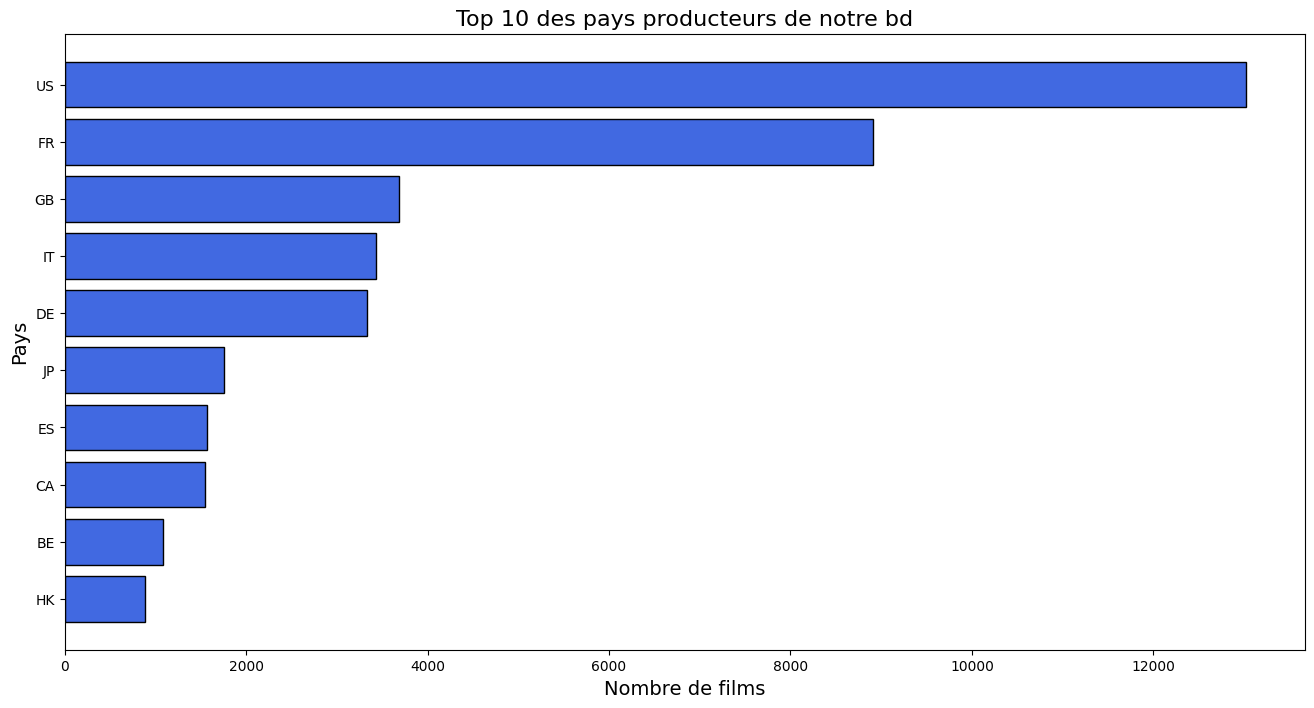

In [244]:
total = df.explode('production_countries')['production_countries'].value_counts()[:10]

plt.figure(figsize=(16, 8))
plt.barh(
    total.index,
    total.values,
    color='royalblue',
    edgecolor='black'
)
plt.title('Top 10 des pays producteurs de notre bd', fontsize=16)
plt.xlabel('Nombre de films', fontsize=14)
plt.ylabel('Pays', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

In [245]:
df[df["titre_str"].str.contains("Avatar")]

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,production_countries,revenue,spoken_languages,status,titleId,region,cuts
19756,tt0499549,Avatar,2009,162,"[Action, Adventure, Fantasy]",7.90,1362820,en,Avatar,188.10,"[US, GB]",2923706026.00,"[en, es]",Released,tt0499549,FR,2000-2009
25941,tt1630029,Avatar: The Way of Water,2022,192,"[Action, Adventure, Fantasy]",7.60,463665,en,Avatar: The Way of Water,2857.87,[US],2319331580.00,[en],Released,tt1630029,FR,>2020


In [246]:
df.shape

(36229, 17)

In [247]:
# # On filtre les films qui sont déja sortie au cinéma
# year_now = datetime.now().year

# condi = (
#     (df["person_job"].str.contains("act")) &
#     (df["titre_date_sortie"] <= year_now)
# )
# df = df[condi]
# actor = df.copy()

# """
# La moyenne d'age des acteurs a la date de sortie du film.
# Nous calculons la mediane sur cette base.

# other KPI, calcul la moyenne des ages en fonction de l'année

# """
# # ajouter colonne age pour les personnes
# actor["person_age"] = np.where(
#     (actor["person_birthdate"] > 1800) &
#     (actor["titre_date_sortie"] > 1800) &
#     (actor["titre_date_sortie"] - actor["person_birthdate"] >= 0),
#     (actor["titre_date_sortie"] - actor["person_birthdate"]),
#     0
# )
# actor.tail()

In [248]:
# df.info()

In [249]:
# """
# imagine un fonction, qui prendrais en argument une liste de date de
# titre de sortie et retourne la moyenne d'age de ces années des acteurs.

# # Quels sont les acteurs les plus présents ?
# # À quelle période ?
# La durée moyenne des films s'allonge ou se raccourcit avec les années ?
# Les acteurs de série sont-ils les mêmes qu'au cinéma ?
# # Les acteurs ont en moyenne quel âge ?
# Quels sont les films les mieux notés ?
# Partagent-ils des caractéristiques communes ? etc...

# """

# bins, names = bins_generator(actor["titre_date_sortie"].max())

# actor["cuts"] = pd.cut(
#     actor["titre_date_sortie"],
#     bins=bins,
#     labels=names
# )

# actor_median = []
# for date in names[1:]:
#     condi = (
#         (actor["person_age"] != 0) &
#         (actor["cuts"] == date)
#     )
#     # print(f"Mediane for person_age {date} :", actor["person_age"][condi].median())
#     actor_median.append(actor["person_age"][condi].median())

# plt.figure(figsize=(10,6))
# plt.bar(names[1:], actor_median, color="royalblue")
# plt.xlabel("Années des film")
# plt.ylabel("Mediane")
# plt.title("Mediane acteur vs année")
# plt.xticks(rotation=45)
# plt.tight_layout()

In [250]:
# # Top 5 des acteurs all time !
# print(actor["person_name"].value_counts().head(5))
# # Bottom 5 des acteurs all time !
# print(actor["person_name"].value_counts().tail(5))

In [251]:
# # Top 5 actors by years
# for date in names[1:]:
#     top5 = actor['person_name'][condi].value_counts().head(5)
#     condi = (
#         (actor["cuts"] == date)
#     )
#     top5_str = '\n'.join(str(top5).split('\n')[:-1])

#     print(f"Top 5 actors by movies for {date}\n{'-'*20}\n{top5_str}")
#     print("-"*20)


In [252]:
# #  World record of the longest documentary
# # source :https://fr.wikipedia.org/wiki/Ambianc%C3%A9
# longest = actor[actor["titre_duree"] == 43200]
# n = longest[["titre_str", "titre_duree"]].iloc[0]
# heure = n["titre_duree"] // 60
# jours = heure // 24
# print(f"Le film le plus long est {n['titre_str']} d'une durée de {heure} heures soit {jours} jours")
# # All time median for duration
# print(f"All time duration median : {round(actor['titre_duree'].median())} minutes")

In [253]:
# # Median duration for movies between years.
# nodup = actor[~actor["titre_str"].duplicated(keep="first")]

# for date in names[1:]:
#     condi = (
#         (nodup["cuts"] == date)
#     )
#     med = round(nodup["titre_duree"][condi].median())
#     print(f"Median durations for movies {date}\nMedian for this years is {med} minutes")
#     print("-"*20)

In [254]:
# print(len(yy[yy["titre_date_sortie"].isna()]))
# yy["titre_date_sortie"].fillna(1678, inplace=True)
# yy["person_birthdate"] = yy["person_birthdate"].astype(int).replace(0, 1678)
# condi = (
#     yy["person_birthdate"] < 1678
# )

# yy.loc[condi, "person_birthdate"] = 1678
# datime_col = ["titre_date_sortie", "person_birthdate"]
# for time in datime_col:
#     yy[time] = pd.to_datetime(yy[time], format="%Y")
# yy["titre_date_sortie"] = yy["titre_date_sortie"].dt.year